In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
! git clone https://github.com/FatimaZohraBoumhaout/Occlusion/blob/main/Occlusion.ipynb

Cloning into 'Occlusion.ipynb'...
fatal: repository 'https://github.com/FatimaZohraBoumhaout/Occlusion/blob/main/Occlusion.ipynb/' not found


In [3]:
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 9.5 MB/s 
     |████████████████████████████████| 6.6 MB 6.4 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=527dda2324205a93bbda6b6cecb60cc5aea53ae228b2a9963d09da08ee130c61
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree


In [4]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random
import torch.nn as nn

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [5]:
import sys
import numpy as np
import requests
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

sys.path.append('./VisualFeatureSearch')
# from vissearch import widgets, util, data
# from vissearch.searchtool import LiveSearchTool, get_crop_rect

In [6]:
from __future__ import annotations
import numpy as np
import zarr

import torch
from torch.utils.data import DataLoader, Dataset

def get_crop_rect(query_mask: np.ndarray, threshold=0) -> tuple[int]:
    '''crops a mask'''
    rows, cols = np.where(query_mask > threshold)
    top = np.min(rows)
    bot = np.max(rows) + 1
    left = np.min(cols)
    right = np.max(cols) + 1
    return top, left, bot, right

class SearchTool:
    '''Base class for searching across feature tensors. `compute()` is not implemented here, so
       it is recommended to use `CachedSearchTool` or `LiveSearchTool` instead.'''

    def __init__(self, model, device):
        self._model = model
        self._device = device

    def set_input_image(self, query_image: torch.Tensor):
        '''Assumes `query_image` is already preprocessed'''
        query_image = query_image.to(self._device)
        self._query_features = self._model(query_image[None, :, :, :]).to(self._device)

    def compute(self, query_mask):
        raise NotImplementedError('Do not use the SearchTool base class')

    def compute_batch(self, query_mask: np.ndarray, batch_arr: np.ndarray | torch.Tensor) -> tuple[torch.Tensor]:
        '''Computes cosine similarities for a single batch.'''
        top, left, bot, right = get_crop_rect(query_mask)
        cropped_mask = query_mask[top:bot, left:right]
        cropped_query_features = self._query_features[..., top:bot, left:right]

        # TODO: doing this once per batch is a potential bottleneck -- switch to doing it once
        mask_tensor = torch.tensor(cropped_mask).to(self._device)
        mask_tensor = mask_tensor[None, None, :, :] # reshape to match feature tensors

        region_query_features = cropped_query_features * mask_tensor
        norm_query_features = region_query_features \
            / torch.linalg.vector_norm(region_query_features, dim=[1, 2, 3], keepdim=True)

        q_height = bot - top
        q_width = right - left

        width = batch_arr.shape[3]
        height = batch_arr.shape[2]

        if isinstance(batch_arr, np.ndarray):
            batch_vecs = torch.from_numpy(batch_arr)
        else:
            batch_vecs = batch_arr
        
        batch_vecs = batch_vecs.to(self._device)
        batch_sims = torch.zeros(len(batch_vecs)).to(self._device)
        batch_xs = torch.zeros(len(batch_vecs)).to(self._device)
        batch_ys = torch.zeros(len(batch_vecs)).to(self._device)

        # CONVOLUTION IDEAS
        # goal is to find cos(theta) = A . B / (||A|| * ||B||)
        # - first do convolution between batch_vecs (tensor) and norm_query_features*mask_tensor (kernel)
        # - batch_vecs is not normalized, so we need to find vector mag. for each window we used
        #   - this can be done by first doing batch_vecs * batch_vecs (element-wise)
        #   - then, we can do a second convolution between squared vecs and the mask tensor to get squared magnitude
        #   - then just divide convolution outputs element-wise

        scaledSims = torch.conv2d(batch_vecs.double(), norm_query_features * mask_tensor)

        sq_batch_vecs = batch_vecs * batch_vecs
        sq_mask_tensor = mask_tensor * mask_tensor
        batch_mags = torch.conv2d(sq_batch_vecs.double().view(-1, 1, height, width), sq_mask_tensor)
        batch_mags = batch_mags.view(batch_vecs.shape[0], 
                                     batch_vecs.shape[1],
                                     height - q_height + 1,
                                     width - q_width + 1)
        batch_mags = torch.sum(batch_mags, 1, keepdim=True)
        batch_mags = torch.sqrt(batch_mags) + 1e-5 # add small eps to avoid NaN values

        window_sims = scaledSims / batch_mags
        window_sims = window_sims.view(window_sims.shape[0], -1)

        batch_sims, idxs = window_sims.max(dim=1)
        batch_xs = idxs % (width - q_width + 1)
        batch_ys = torch.div(idxs, width - q_width + 1, rounding_mode='floor')

        return batch_sims, batch_xs, batch_ys

class LiveSearchTool(SearchTool):
    '''Implementation of `SearchTool` that computes features on the fly. 
       Does not require a precomputed feature cache, but should only be used with
       small/medium datasets.'''
    def __init__(self, model, device, dataset: Dataset, batch_size=64):
        super().__init__(model, device)
        self._dataset = dataset
        # get all feature vectors from dataset
        self._all_vecs = self.__get_feature_vecs(batch_size)

    def __get_feature_vecs(self, batch_size):
        dl = DataLoader(self._dataset, batch_size)
        with torch.no_grad():
            it = iter(dl)
            all_vecs = []
            for batch in it:
                batch = batch.to(self._device)
                all_vecs.append(self._model(batch).cpu())
                del batch
        return all_vecs
    
    @torch.no_grad()
    def compute(self, query_mask):
        sims = []
        xs = []
        ys = []
        for batch in self._all_vecs:
            batch_sims, batch_xs, batch_ys = self.compute_batch(query_mask, batch)
            sims.append(batch_sims)
            xs.append(batch_xs)
            ys.append(batch_ys)
        return torch.cat(sims), torch.cat(xs), torch.cat(ys)

class CachedSearchTool(SearchTool):
    '''Implementation of `SearchTool` that uses a precomputed cache to efficiently 
       compute search results. See `caching.py` for creating a new cache.''' 
    def __init__(self, model, cache: zarr.Array, device, batch_size=500):
        super().__init__(model, device)
        self._cache = cache
        self._batch_size = batch_size

    @torch.no_grad()
    def compute(self, query_mask):
        sims = []
        xs = []
        ys = []
        for i in range(0, len(self._cache), self._batch_size):
            batch_arr = self._cache[i:i + self._batch_size]
            batch_sims, batch_xs, batch_ys = self.compute_batch(query_mask, batch_arr)
            sims.append(batch_sims)
            xs.append(batch_xs)
            ys.append(batch_ys)
        return torch.cat(sims), torch.cat(xs), torch.cat(ys)

In [7]:
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image

import os

# from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L227
net_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # note to future self: cannot be used for masks
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

vis_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

class SimpleDataset(Dataset):
    ''' A basic PyTorch dataset we use for some small-scale experiments.
        Works well with VFS, but is not required. '''
    def __init__(self, path, transform=net_transform, return_idxs=True):
        self._path = path
        self._all_images = sorted(os.listdir(path))
        self.transform = transform 
        self.return_idxs = return_idxs
    
    def __len__(self):
        return len(self._all_images)

    def __getitem__(self, idx):
        img_path = os.path.join(self._path, self._all_images[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if self.return_idxs:
            return image, idx
        else:
            return image
    
    # get the image at index idx as a PIL object
    def get_vis_image(self, idx):
        img_path = os.path.join(self._path, self._all_images[idx])
        image = Image.open(img_path)

        # use visual transform
        image = vis_transform(image)
        return image

In [8]:
from PIL import Image
from io import BytesIO
import base64
from typing import Callable

import numpy as np
import cv2
#from vissearch.searchtool import get_crop_rect

def image_to_durl(img : Image):
    ''' Converts a PIL Image to a data URL '''
    img_bin = BytesIO()
    img.save(img_bin, format='JPEG')
    img_b64 = base64.b64encode(img_bin.getvalue()).decode('ascii')
    return 'data:image/jpeg;base64, ' + str(img_b64)

def durl_to_image(url : str):
    ''' Converts a data URL to a PIL Image '''
    data_b64 = url.split(',')[1]
    data = base64.b64decode(data_b64)
    img_bin = BytesIO(data)
    return Image.open(img_bin)

def create_callback(name : str, func : Callable):
    ''' Required to create a JS-Python Callback in Google Colab '''
    try:
        from google.colab import output
        output.register_callback(name, func)
    except:
        pass

def crop_mask(mask):
  ''' crop all zero-valued rows/cols on the outside of the image '''
  top, left, bot, right = get_crop_rect(mask)
  return mask[top:bot, left:right]

def mask_overlay(image: Image, 
                 x: int, y: int, 
                 mask_size: int, mask: np.ndarray,
                 alpha: int = 0.7, beta: int = 0.4) -> np.ndarray:
    '''add a `mask` over a given `image`.
    
       The image result is `image * alpha + mask * beta`'''

    img = np.asarray(image, dtype=np.float32)
    img /= 256
    img *= alpha

    full_mask = np.zeros((mask_size,mask_size))
    full_mask[y:y+mask.shape[0], x:x+mask.shape[1]] = mask
    full_mask = cv2.resize(full_mask, (224, 224), interpolation=cv2.INTER_NEAREST)
    full_mask *= beta

    if len(img.shape) == 3:
        img[:, :, 0] += full_mask
        img[:, :, 1] += full_mask
        img[:, :, 2] += full_mask
    else:
        img += full_mask

    return np.minimum(img, 1)

In [9]:
import random

# common JS code for executing callbacks into Python
CALLBACK_JS = '''
<script>
    function isCallbackSupported() {
        return (typeof Jupyter !== 'undefined') || (typeof google !== 'undefined');
    }
    function executeCallback(function_name, data) {
        if (typeof Jupyter !== 'undefined') {
            let call_statement = function_name + '("' + data + '")';
            Jupyter.notebook.kernel.execute(call_statement);
        } else if (typeof google !== 'undefined') {
            google.colab.kernel.invokeFunction(function_name, [data], {});
        }
    }
</script>
'''

HIGHLIGHT_HTML = '''
<div class="container" style="width: {sz}px; height: {sz}px;">
    <div class="image" style="background-image: url('{url}'); width: {sz}px; height: {sz}px;"></div>
    <canvas 
        id="drawCanvas_{N}"
        class="overlay" 
        style="z-index: 10; width: {sz}px; height: {sz}px;"
    ></canvas>
</div>
<br>
<button id="resetBtn_{N}">Reset</button>
<style>
    .container {{
        position: relative;
        display: inline-block;
    }}
    .image, .overlay {{
        position: absolute;
        left: 0px;
        top: 0px;
    }}
    .overlay {{
        opacity: 0.5;
        transition: opacity .1s ease-in-out;
    }}
    .overlay:hover {{
        opacity: 0.7;
    }}
</style>
<script>
(function() {{
    let resetBtn = document.getElementById('resetBtn_{N}');
    let drawCanvas = document.getElementById('drawCanvas_{N}');
    drawCanvas.width = {sz};
    drawCanvas.height = {sz};
    let ctx = drawCanvas.getContext('2d');
    let drawing = false;
    function mouseDown() {{
        drawing = true;
    }}
    function mouseUp() {{
        drawing = false;
        if('{callName}' !== 'None') {{
            executeCallback('{callName}', drawCanvas.toDataURL());
        }}
    }}
    function handleMove(e) {{
        if(!drawing) return;
        ctx.fillStyle = '#fff';
        ctx.beginPath();
        ctx.arc(e.offsetX, e.offsetY, {hlghtRad}, 0, 2 * Math.PI);
        ctx.fill();
    }}
    function reset() {{
        ctx.clearRect(0, 0, {sz}, {sz});
        if('{callName}' !== 'None') {{
            executeCallback('{callName}', drawCanvas.toDataURL());
        }}
    }}
    drawCanvas.onmousedown = mouseDown;
    drawCanvas.onmouseup = mouseUp;
    drawCanvas.onmousemove = handleMove;
    resetBtn.onclick = reset;
}})();
</script>
'''

########################################################################

MULTI_HIGHLIGHT_HTML = '''
<div style="height: {sz}px; margin-bottom: 5px;">
    <div class="container" style="width: {sz}px; height: {sz}px; float: left">
        <div class="image" id="currImgDiv_{N}" style="width: {sz}px; height: {sz}px;"></div>
        <canvas 
            id="drawCanvas_{N}"
            class="overlay" 
            style="z-index: 10; width: {sz}px; height: {sz}px;"
        ></canvas>
    </div>
    <div class="photos" id="photosDiv_{N}" style="height: {sz}px; float: left;">
    </div>
</div>
<button id="resetBtn_{N}">Reset</button>
<style>
    .container {{
        position: relative;
        display: inline-block;
    }}
    .image, .overlay {{
        position: absolute;
        left: 0px;
        top: 0px;
    }}
    .overlay {{
        opacity: 0.5;
        transition: opacity .1s ease-in-out;
    }}
    .overlay:hover {{
        opacity: 0.7;
    }}
    .photos {{
        display: flex;
        flex-direction: column;
        align-items: flex-start;
        /* justify-content: space-between; */
        flex-wrap: wrap;
        gap: 6px;
        margin-left: 10px;
        border-left: 3px solid black;
        padding-left: 10px;
    }}
    .photoBtn {{
        width: 40px;
        height: 40px;
        margin-top: 0px !important;
        margin-right: 2px;
        flex-basis: 40px;
        transition: opacity .05s ease-in-out;
    }}
    .photoBtn:hover {{
        opacity: 0.7;
    }}
</style>
<script>
(function() {{
    let photosDiv = document.getElementById('photosDiv_{N}');
    let currImgDiv = document.getElementById('currImgDiv_{N}');
    let resetBtn = document.getElementById('resetBtn_{N}');
    let drawCanvas = document.getElementById('drawCanvas_{N}');
    drawCanvas.width = {sz};
    drawCanvas.height = {sz};
    let ctx = drawCanvas.getContext('2d');
    let drawing = false;
    let urls = {urls};
    let selected = 0;
    function mouseDown() {{
        console.log('hello');
        drawing = true;
    }}
    function mouseUp() {{
        drawing = false;
        if('{callName}' !== 'None') {{
            executeCallback('{callName}', [drawCanvas.toDataURL(), selected]);
        }}
    }}
    function handleMove(e) {{
        if(!drawing) return;
        ctx.fillStyle = '#fff';
        ctx.beginPath();
        ctx.arc(e.offsetX, e.offsetY, {hlghtRad}, 0, 2 * Math.PI);
        ctx.fill();
    }}
    function reset() {{
        console.log('reset');
        ctx.clearRect(0, 0, {sz}, {sz});
        if('{callName}' !== 'None') {{
            executeCallback('{callName}', [drawCanvas.toDataURL(), selected]);
        }}
    }}
    function photoChange(e) {{
        let idVal = e.target.id;
        let index = idVal.split('_')[1];
        if(selected != index) {{
            selected = index;
            currUrl = urls[selected];
            currImgDiv.style.backgroundImage = "url('" + currUrl + "')";
            reset();
        }}
    }}
    for(let i = 0; i < urls.length; i++) {{
        let elem = document.createElement('img');
        elem.classList.add("photoBtn");
        elem.id = "photoBtn{N}_" + i;
        elem.src = urls[i];
        elem.onclick = photoChange;
        photosDiv.append(elem);
    }}
    currImgDiv.style.backgroundImage = "url('" + urls[0] + "')";
    drawCanvas.onmousedown = mouseDown;
    drawCanvas.onmouseup = mouseUp;
    drawCanvas.onmousemove = handleMove;
    resetBtn.onclick = reset;
    console.log(resetBtn);
}})();
</script>
'''

class HighlightWidget:
    ''' A Jupyter notebook widget for interactively selecting a specific region within an image.'''
    def __init__(self, img_url, callback_name=None, size=224, highlight_radius=20):
        self._img_url = img_url
        self._callback_name = callback_name
        self._size = size
        self._highlight_radius = highlight_radius

        # use a random number to ensure we never repeat identical HTML IDs
        self._id_suffix = random.randint(0, 1000000000)

    def _repr_html_(self):
        return CALLBACK_JS + HIGHLIGHT_HTML.format(
            N = self._id_suffix,
            sz = self._size, 
            url = self._img_url, 
            hlghtRad = self._highlight_radius,
            callName = self._callback_name
        )

class MultiHighlightWidget:
    def __init__(self, all_urls, callback_name=None, size=224, highlight_radius=20):
        self._all_urls = all_urls
        self._callback_name = callback_name
        self._size = size
        self._highlight_radius = highlight_radius

        # use a random number to ensure we never repeat identical HTML IDs
        self._id_suffix = random.randint(0, 1000000000)

    def _repr_html_(self):
        return CALLBACK_JS + MULTI_HIGHLIGHT_HTML.format(
            N = self._id_suffix,
            sz = self._size,
            urls = self._all_urls,
            hlghtRad = self._highlight_radius,
            callName = self._callback_name
        )

In [10]:
IMAGENET_MU = [0.485, 0.456, 0.406]
IMAGENET_SIGMA = [0.229, 0.224, 0.225]


class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super(NormalizeInverse, self).__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super(NormalizeInverse, self).__call__(tensor.clone())


class Clip(object):
    """Pytorch transformation that clips a tensor to be within [0,1]"""
    def __init__(self):
        return

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): tensor to be clipped.
        Returns:
            Tensor: clipped tensor.
        """
        t = tensor.clone()
        t[t > 1] = 1
        t[t < 0] = 0
        return t


def get_detransform(mu=IMAGENET_MU, sigma=IMAGENET_SIGMA):
    detransform = transforms.Compose([
        NormalizeInverse(mu, sigma),
        Clip(),
        # transforms.ToPILImage(),
    ])
    return detransform

In [11]:
detransform = get_detransform()

In [12]:
dataset250 = pd.read_csv('/content/drive/MyDrive/ImageNet/val_imdb.txt', sep = '/', header = None, names = ["path", "label"])


n = random.randint(0, 250)
print(n)
img_name_label = dataset250.iloc[n, 1]

print('Image name and label: {}'.format(img_name_label))
path, label_str = img_name_label.split()
label = int(label_str)
print('Image name: {}'.format(path))
print('Image label:{}'.format(label))

gdr_path = "/content/drive/MyDrive/ImageNet/val_250/val_250/"

img_path = gdr_path+path
print(img_path)

187
Image name and label: ILSVRC2012_val_00000188.JPEG 272
Image name: ILSVRC2012_val_00000188.JPEG
Image label:272
/content/drive/MyDrive/ImageNet/val_250/val_250/ILSVRC2012_val_00000188.JPEG


Image classification:  'coyote, prairie wolf, brush wolf, Canis latrans'
Image label:272


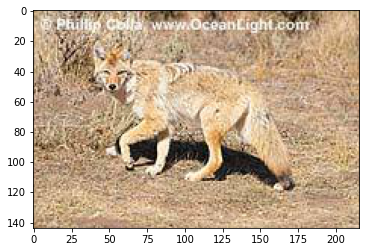

Image type: torch.FloatTensor
Image size: torch.Size([3, 144, 216])


In [13]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

lable_name = pd.read_csv('/content/drive/MyDrive/ImageNet/labels.txt', sep = ':')
class_names = []
for i in range(1000):
  class_names.append(lable_name.iloc[i-1, 1].rstrip(","))

print('Image classification: {}'.format(class_names[label]))
print('Image label:{}'.format(label))
# print(class_names)

# function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file.
image = Image.open(img_path)
rgb_image = pil2tensor(image)

# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))

In [14]:
# download ten query images to use
''' query_img_ids = ["004", "530", "495", "211", "652", "021", "686", "016", "713", "198"]

def load_img(idx: str):
  url = "https://dulrichprojdata.blob.core.windows.net/query-imgs/ILSVRC2012_test_00000" + idx + ".JPEG"
  img = Image.open(requests.get(url, stream=True).raw)
  return img'''

convert_tensor = transforms.ToTensor()

size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # (x - mean) / std
])

# x = convert_tensor(image)

x = transform(image)

query_vis_transform = transforms.Compose([
    transforms.CenterCrop((256,256)),
    transforms.Resize((224,224))
])

query_model_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# query_imgs = [load_img(id) for id in query_img_ids]
query_img = query_vis_transform(image)
# convert images to Data URLs so we can pass them into the HTML widget
query_img_url = image_to_durl(query_img)

print(query_img_url)

highlight_data = None
highlight_index = None
def highlight_callback(data):
    # import pdb; pdb.set_trace();
    # print(data)
    #print(type((data)))
    global highlight_data #, highlight_index
    highlight_data = data # data[0]
    #highlight_index = data[1]
    #print(highlight_index)
create_callback('highlight_callback', highlight_callback)

HighlightWidget(query_img_url, callback_name='highlight_callback')

data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADgAOADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD5/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiig

In [15]:
print(highlight_data)

None


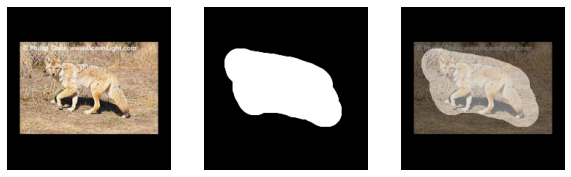

In [17]:
# assert highlight_data is not None, "Use the widget to highlight an image region"

# overlay the mask onto the user's selected image

# curr_img = query_imgs[int(highlight_index)]
# print(highlight_index)

mask = durl_to_image(highlight_data)
mask_arr = np.asarray(mask)[:,:,3] / 256 # take just the alpha channel

curr_mask_overlay = mask_overlay(query_img, x=0, y=0, mask_size=224, mask=mask_arr, alpha=0.5, beta=0.4)

fig = plt.figure(figsize=(10, 3))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(query_img, cmap='gray')

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(mask_arr, cmap='gray')

plt.subplot(1,3,3)
plt.axis('off')
_ = plt.imshow(curr_mask_overlay)

In [18]:
print(mask_arr.shape)
print(mask_arr)

(224, 224)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Mask: 0 and 1 are just defining the areas of the transform, should have different functions for different kinds of transforms:
1. Preservation
2. Deletion
3. Gaussian Blurr
4. Noise

Should just be one outputting function, and take the transform in as a parameter

In [19]:
def score_gen_preserve (img_input, mask_input, model):
  # transform mask
  mask_3d = mask_input.reshape(1, 224, 224)
  msk = torch.from_numpy(mask_3d).float()

  # transform image
  tensor_trans = transforms.ToTensor()
  img_tensor = tensor_trans(img_input)
  img = img_tensor.float()
  
  masked_img = msk * img
  # plt.subplot(1,2,1)
  # plt.axis('off')
  # plt.imshow(masked_img.permute(1,2,0), cmap='gray')
  plot_image(detransform(masked_img))

  # put through model
  with torch.no_grad():
    y_output = model(masked_img.unsqueeze(0))
  
  softmax = nn.Softmax()
  y_softmax = softmax(y_output)
  k = 5
  #sum = y_output.sum()
  #print(sum)


  confidences = np.squeeze(y_output)
  inds = np.argsort(-confidences)
  top_k = inds[:k]
  #top_confidences = confidences[inds]

  print(f'Correct Prediction: {class_names[label]}')
  print('Preservation Model:')
  for i, ind in enumerate(top_k):
    print(f'Class #{i + 1} - {class_names[ind]} - Logit: {y_output[0,ind]:.2f} - Softmax: {100*y_softmax[0,ind]:.2f}%')
    #print(f'Class #{i + 1} - {class_names[ind]} - Confidence: {100*(conf/sum)}%')
  # print(y_output.max())

In [20]:
def score_gen_delete (img_input, mask_input, model):
  # transform mask
  mask_3d = mask_input.reshape(1, 224, 224)
  msk = torch.from_numpy(mask_3d).float()

  # transform image
  tensor_trans = transforms.ToTensor()
  img_tensor = tensor_trans(img_input)
  # print(img_tensor.shape)
  img = img_tensor.float()
  
  masked_img = (1-msk) * img
  # plt.subplot(1,2,2)
  # plt.axis('off')
  # plt.imshow(masked_img.permute(1,2,0), cmap='gray')
  plot_image(detransform(masked_img))

  # put through model
  with torch.no_grad():
    y_output = model(masked_img.unsqueeze(0))

  softmax = nn.Softmax()
  y_softmax = softmax(y_output)
  k = 5
  #sum = y_output.sum()
  #print(sum)


  confidences = np.squeeze(y_output)
  inds = np.argsort(-confidences)
  top_k = inds[:k]
  #top_confidences = confidences[inds]

  print(f'Correct Prediction: {class_names[label]}')
  print('Deletion Model:')
  for i, ind in enumerate(top_k):
    print(f'Class #{i + 1} - {class_names[ind]} - Logit: {y_output[0,ind]:.2f} - Softmax: {100*y_softmax[0,ind]:.2f}%')
    #print(f'Class #{i + 1} - {class_names[ind]} - Confidence: {100*(conf/sum)}%')
  #print(y_output.max())

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

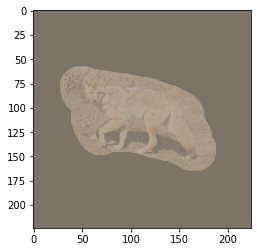

Correct Prediction:  'coyote, prairie wolf, brush wolf, Canis latrans'
Preservation Model:
Class #1 -  'trilobite' - Logit: 10.19 - Softmax: 34.38%
Class #2 -  'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis' - Logit: 8.98 - Softmax: 10.32%
Class #3 -  'isopod' - Logit: 8.36 - Softmax: 5.52%
Class #4 -  'African chameleon, Chamaeleo chamaeleon' - Logit: 8.19 - Softmax: 4.69%
Class #5 -  'ram, tup' - Logit: 8.11 - Softmax: 4.30%


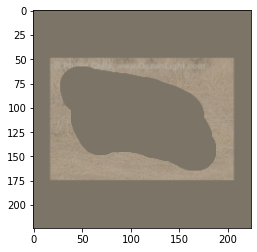

Correct Prediction:  'coyote, prairie wolf, brush wolf, Canis latrans'
Deletion Model:
Class #1 -  'electric ray, crampfish, numbfish, torpedo' - Logit: 12.03 - Softmax: 86.28%
Class #2 -  'stingray' - Logit: 8.19 - Softmax: 1.85%
Class #3 -  'trilobite' - Logit: 7.95 - Softmax: 1.46%
Class #4 -  'cleaver, meat cleaver, chopper' - Logit: 7.72 - Softmax: 1.16%
Class #5 -  'shovel' - Logit: 7.62 - Softmax: 1.05%


In [21]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

score_gen_preserve(query_img, mask_arr, model)
score_gen_delete(query_img, mask_arr, model)